In [10]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

In [11]:
metadata_file = "C:/Users/spigno/Documents/GitHub/PopulationData/MetagenomicData/filtered_metadata.csv"  # Percorso file metadati
metagenomic_data_file = "C:/Users/spigno/Documents/GitHub/PopulationData/MetagenomicData/metagenomic_data_filtered.csv"  # Percorso file dati metagenomici
# Caricare i dataset
metadata_csv = pd.read_csv(metadata_file)
metagenomic_data = pd.read_csv(metagenomic_data_file)

In [12]:
diet= metadata_csv.loc[:,"diet"]

In [13]:
data = metagenomic_data.iloc[:, 1:]

In [14]:
data.replace(0, np.nan, inplace=True)
datat = data.to_numpy()

# Impostazione dei bin logaritmici comuni
bins = np.logspace(-4, 2, 25)
bins_mid = (bins[1:] + bins[:-1]) / 2  # Calcolo dei punti medi dei bin

# Creazione di un DataFrame per salvare gli istogrammi con i nomi delle colonne come intestazione
hist_data = pd.DataFrame(index=bins_mid)

for i in range(data.shape[1]):
    col_name = data.columns[i]
    
    # Calcolo dell'istogramma con binning logaritmico per la colonna corrente
    hist, _ = np.histogram(datat[:, i], bins=bins, density=True)

    # Aggiunta dei risultati al DataFrame con il nome della colonna
    hist_data[col_name] = hist

In [15]:
def powerlaw_model(x, lam,r):
    return  x**(-lam) * np.exp(-r*x) 

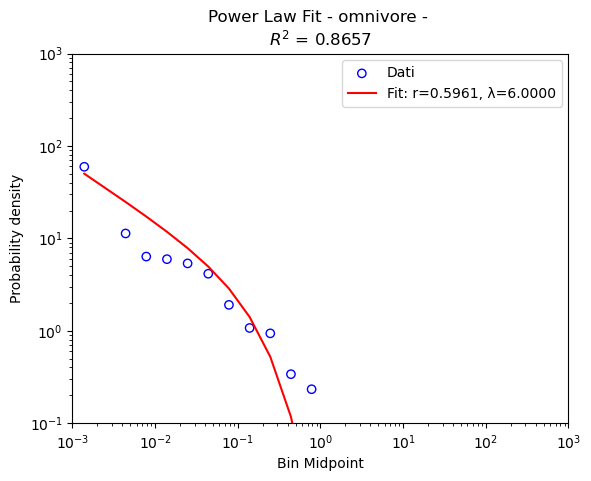

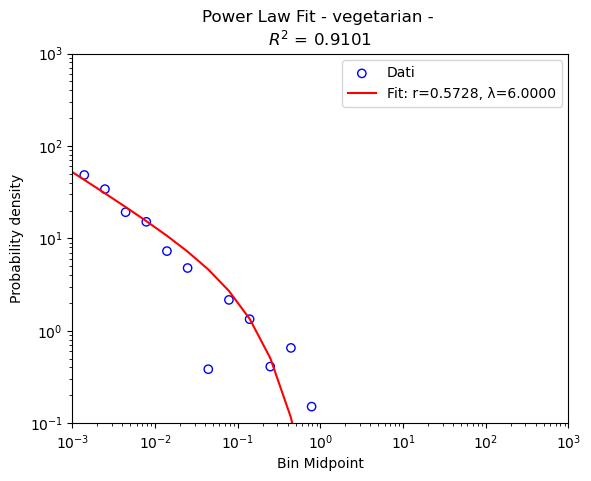

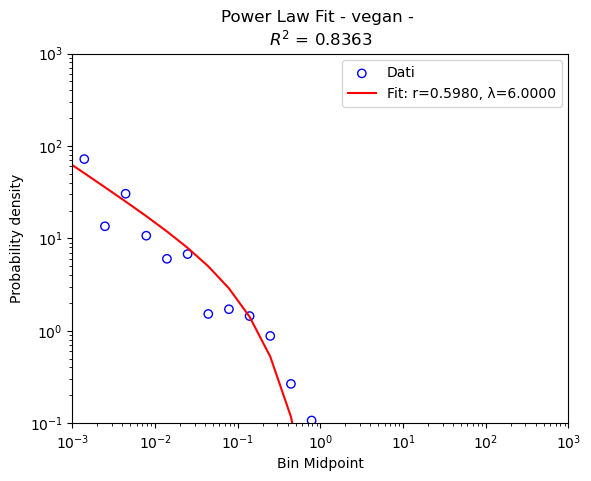

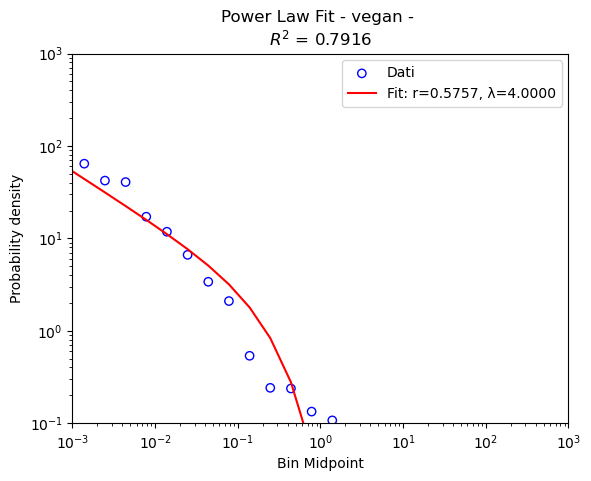

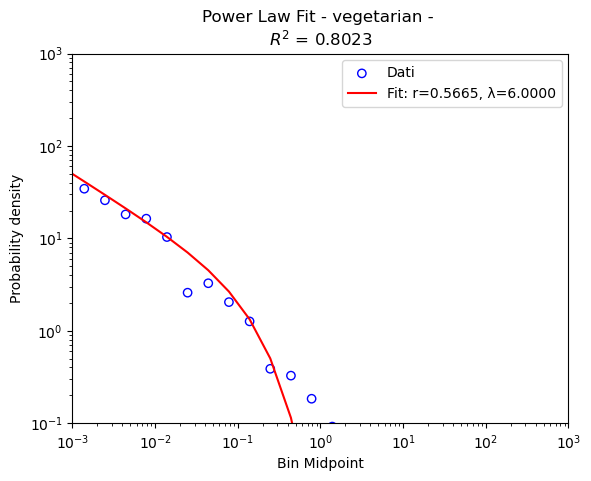

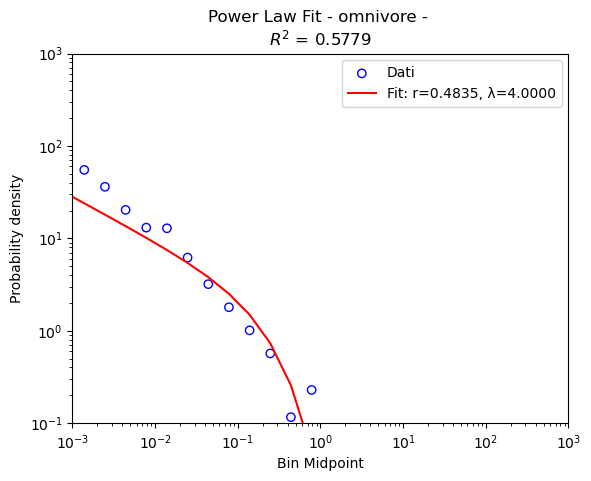

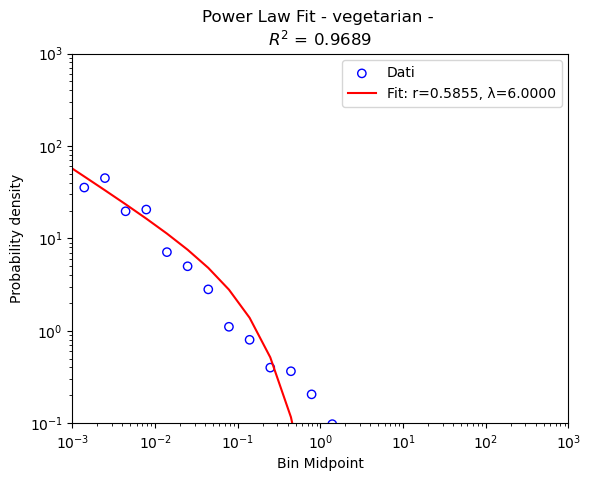

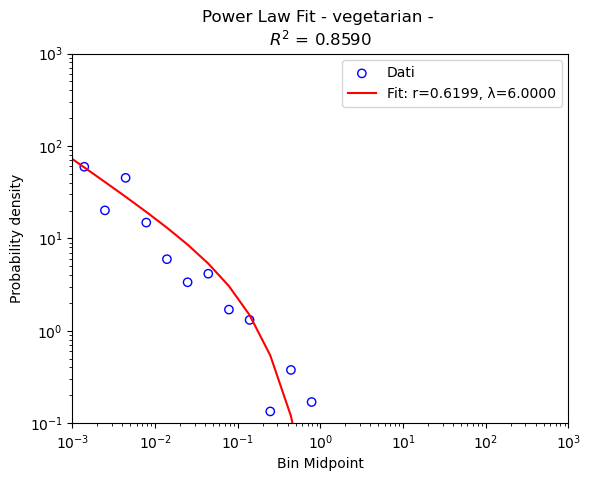

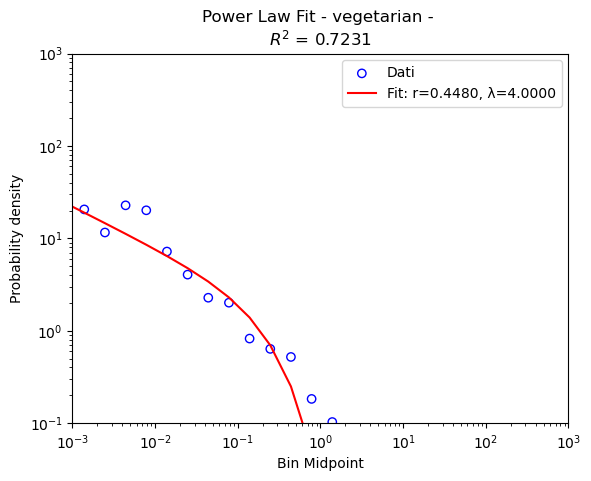

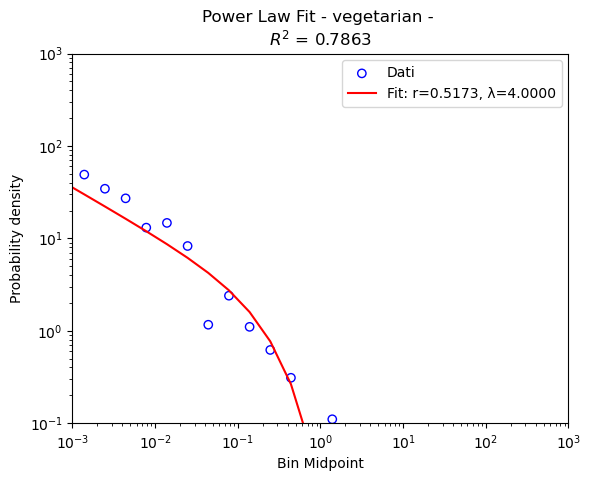

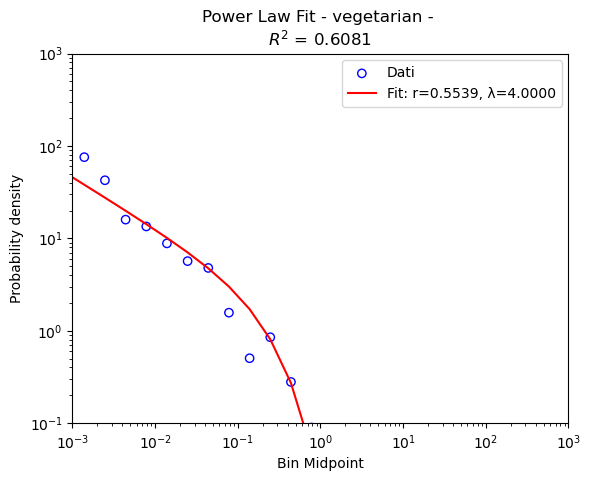

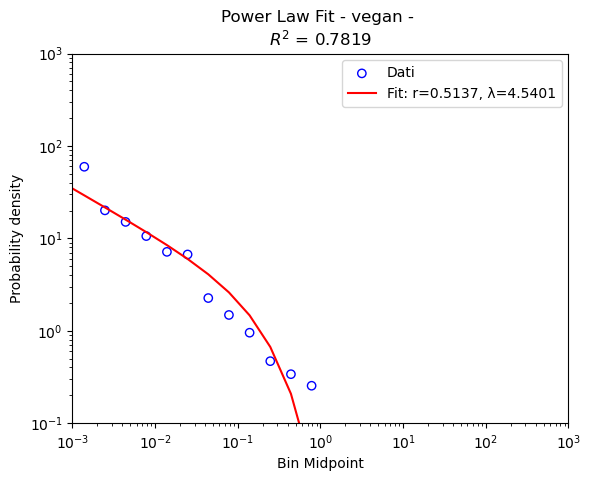

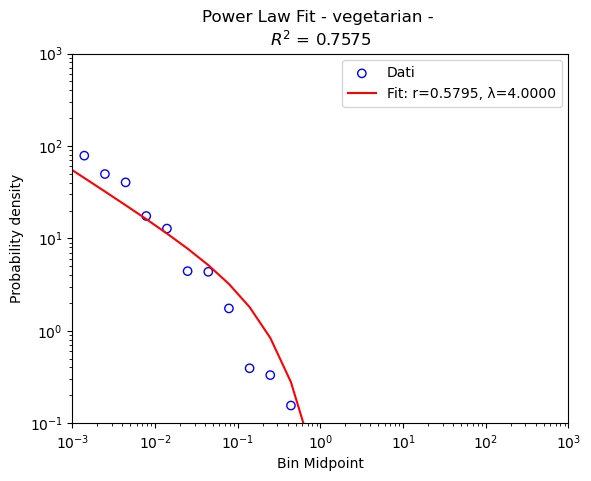

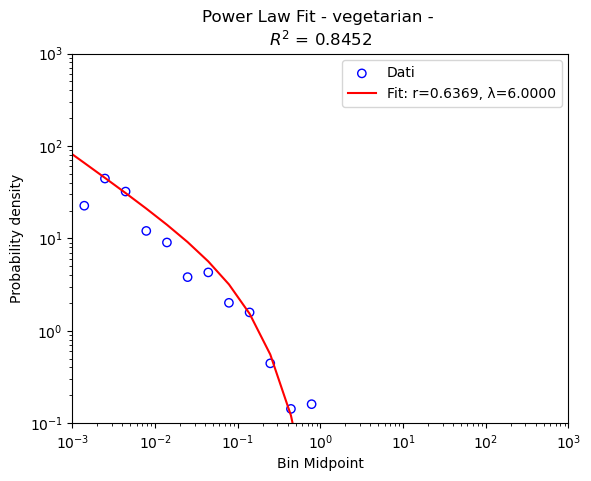

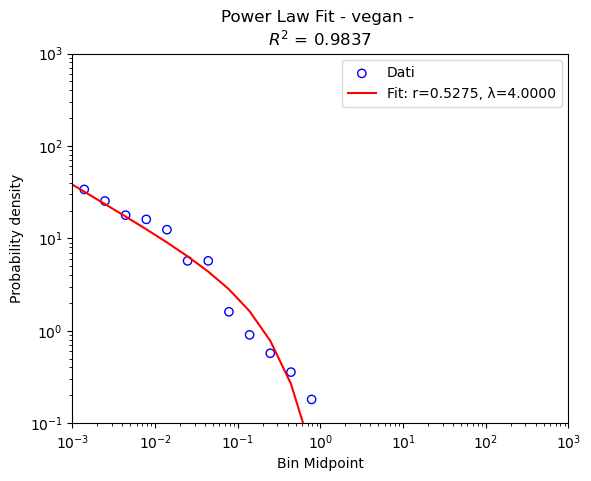

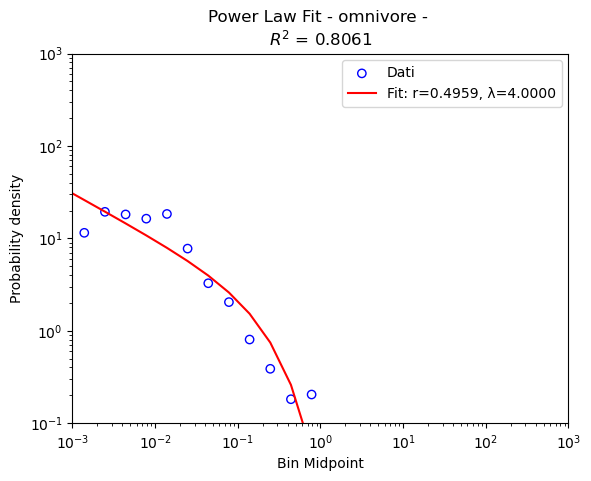

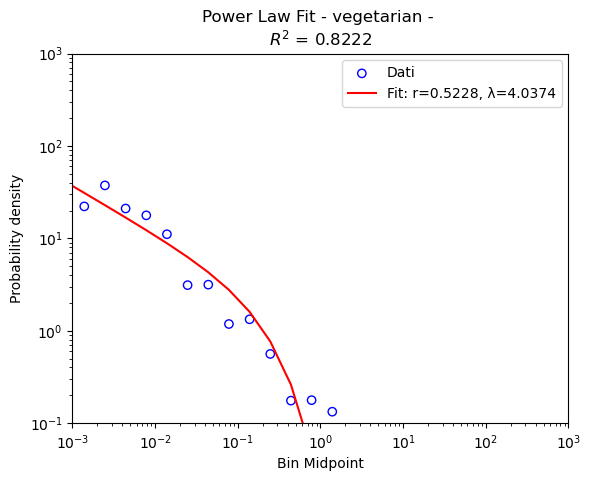

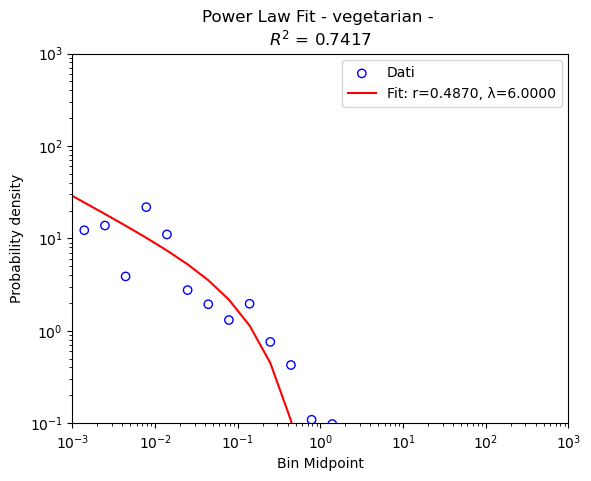

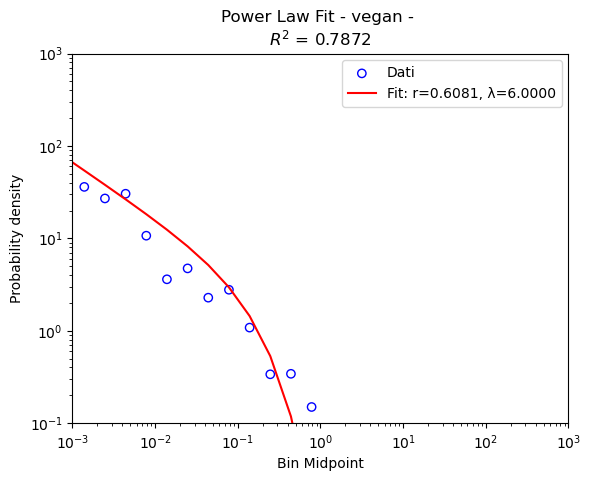

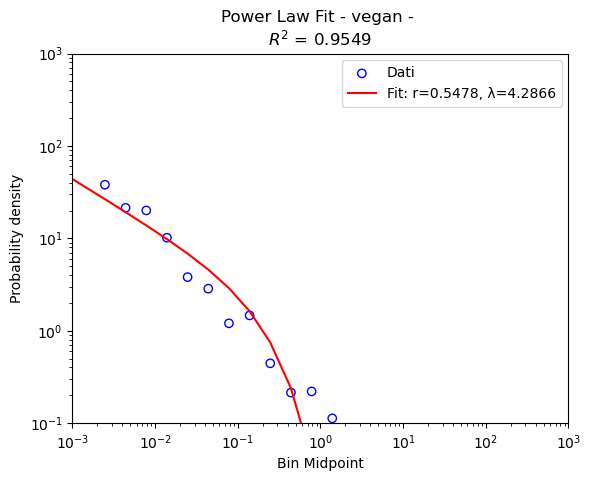

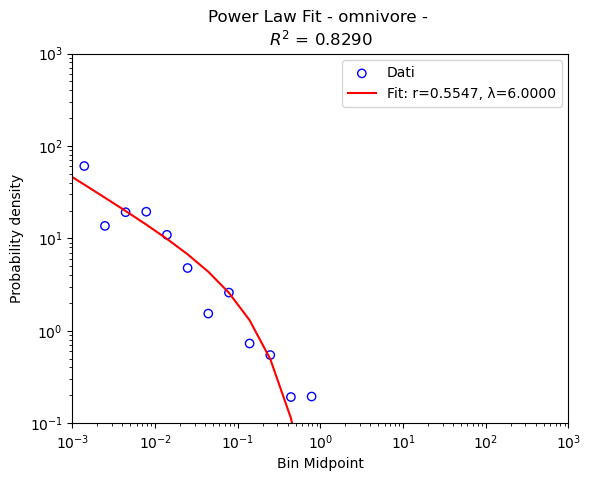

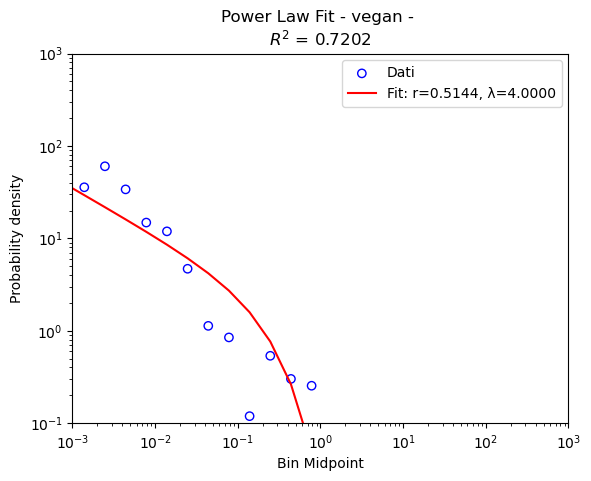

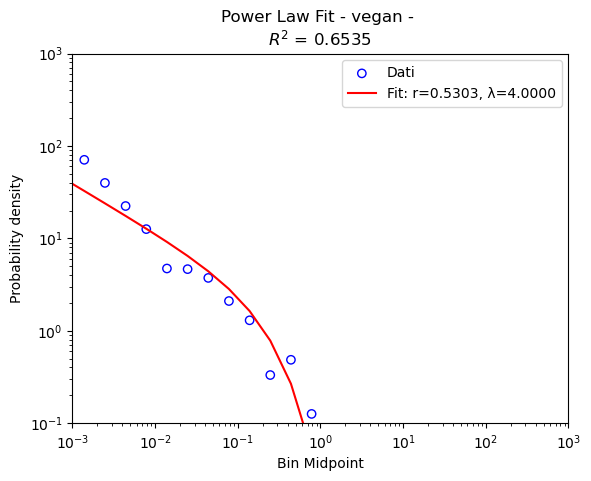

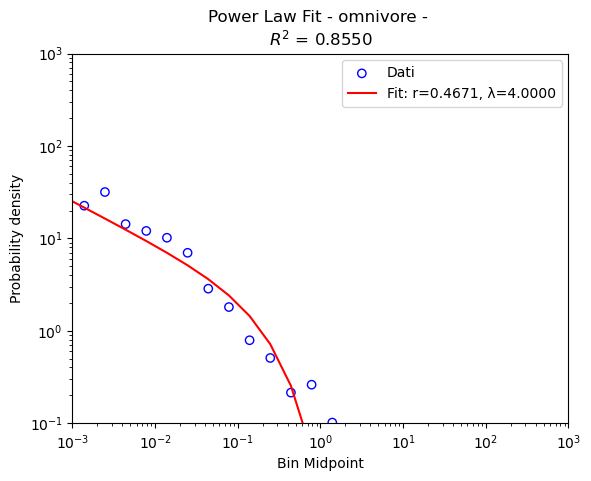

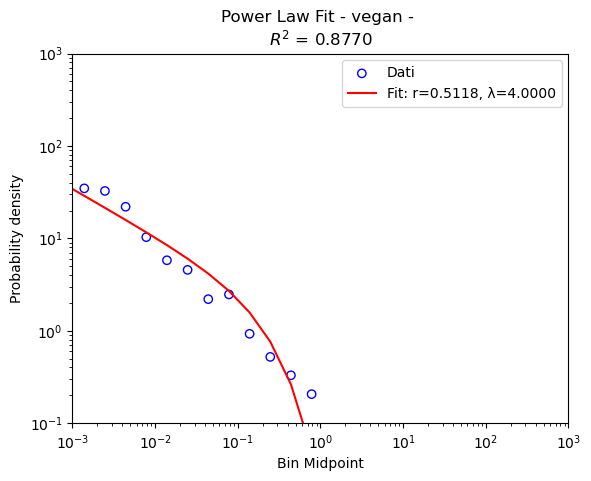

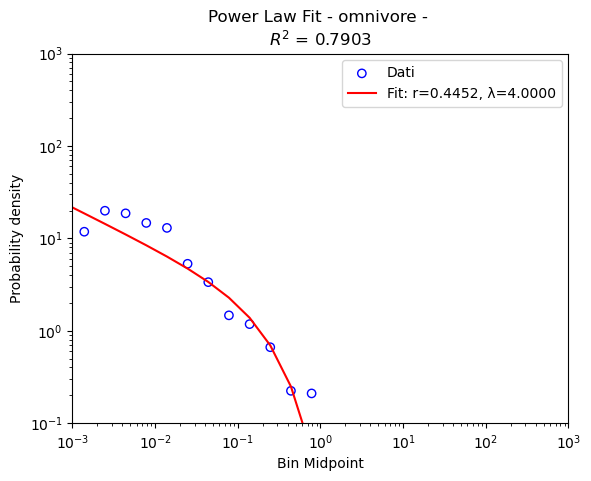

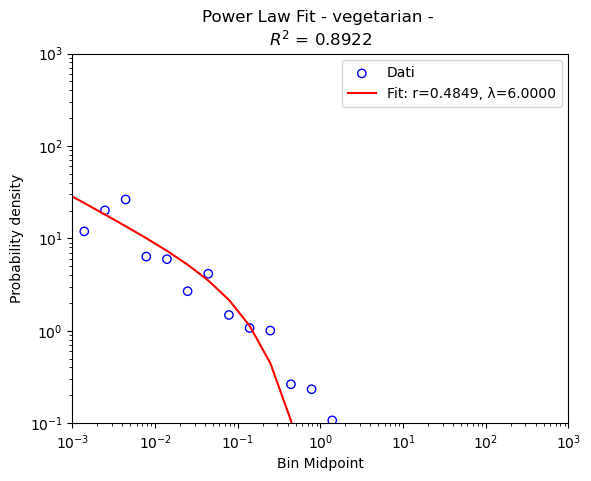

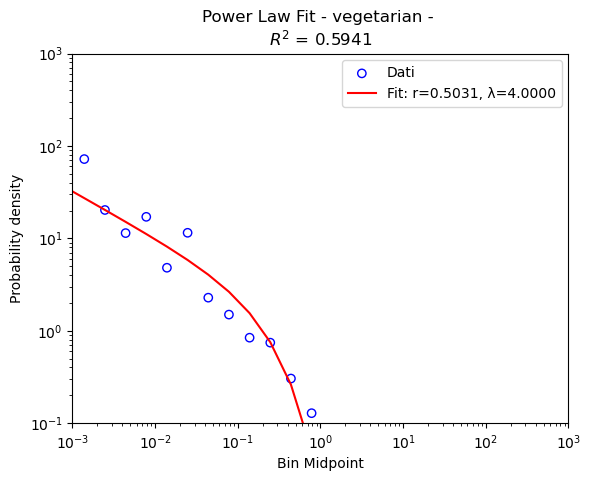

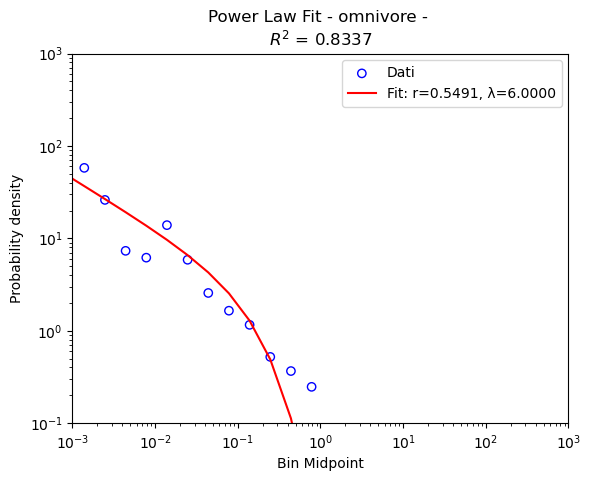

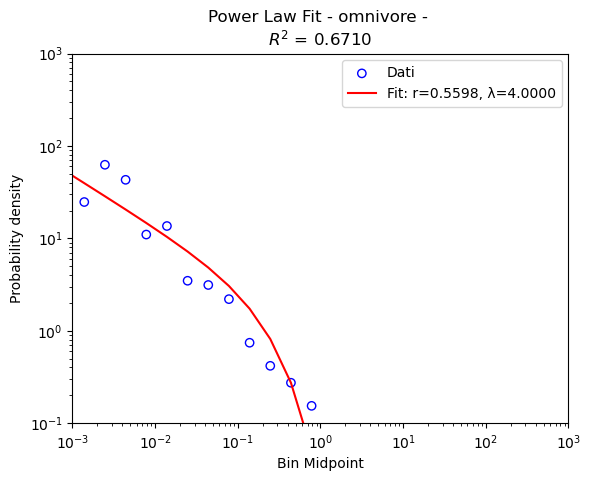

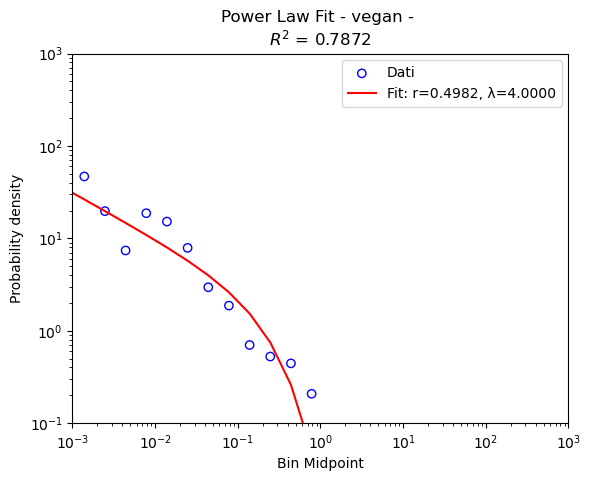

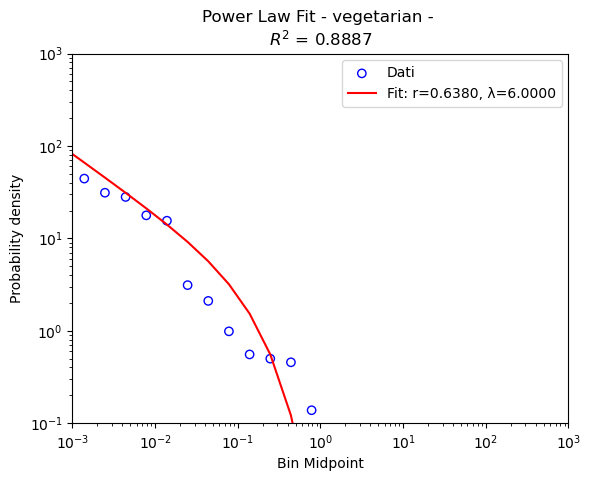

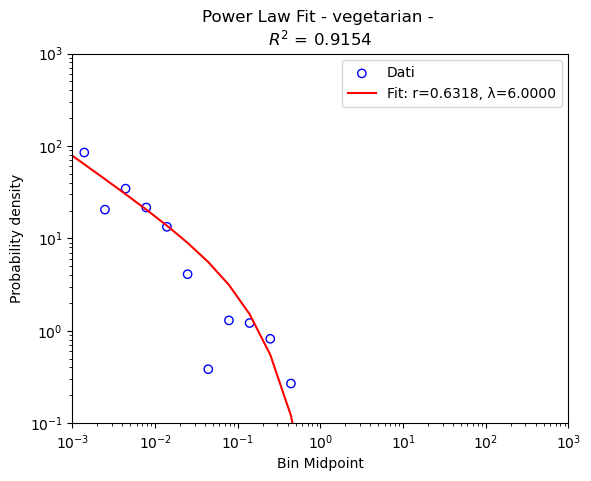

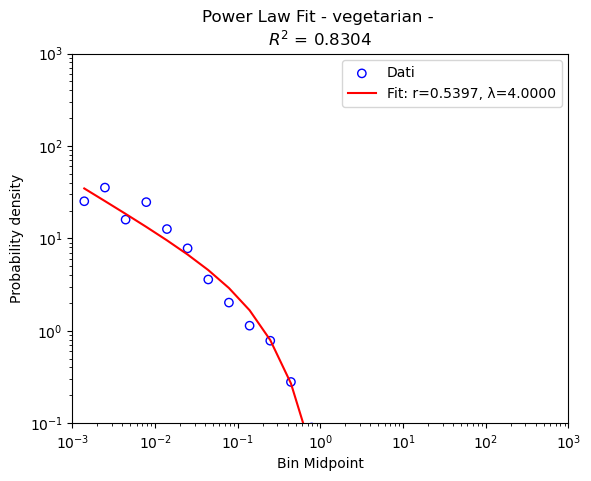

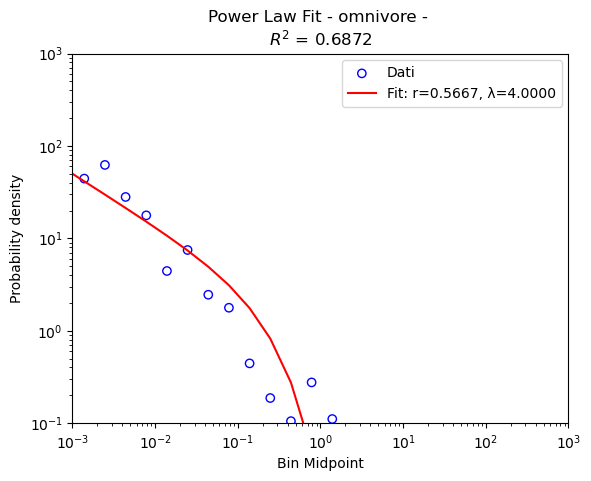

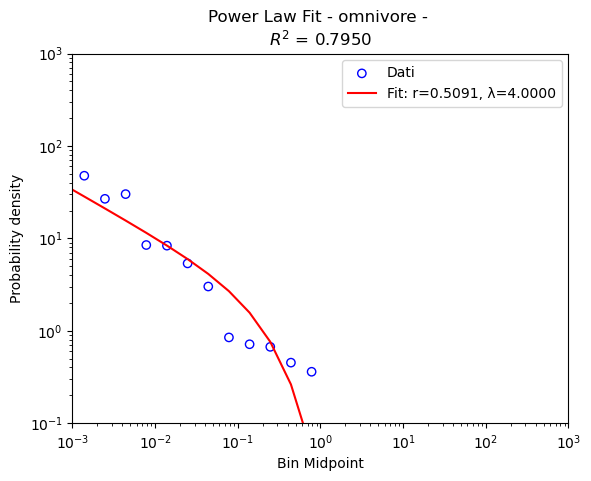

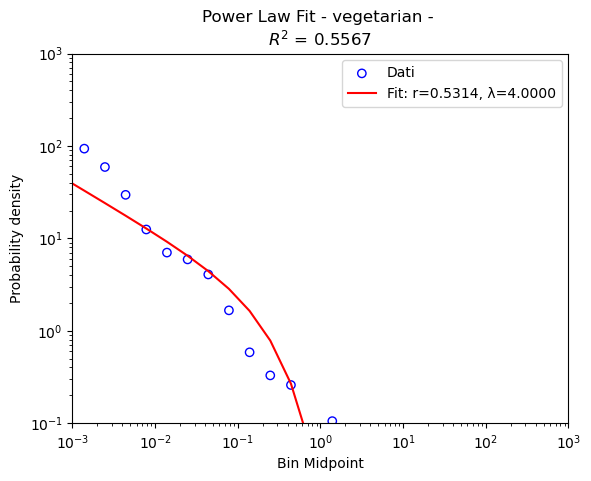

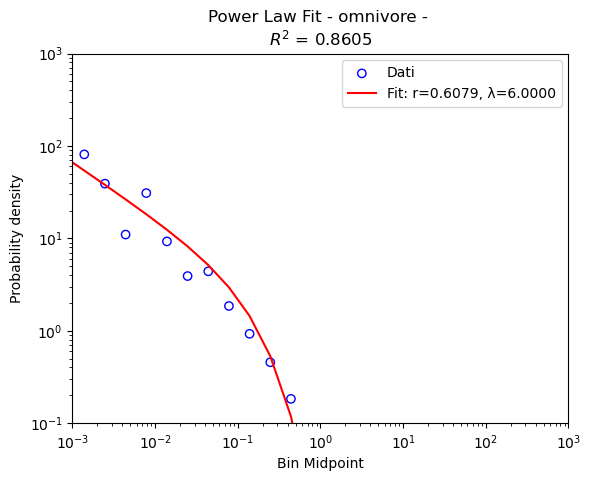

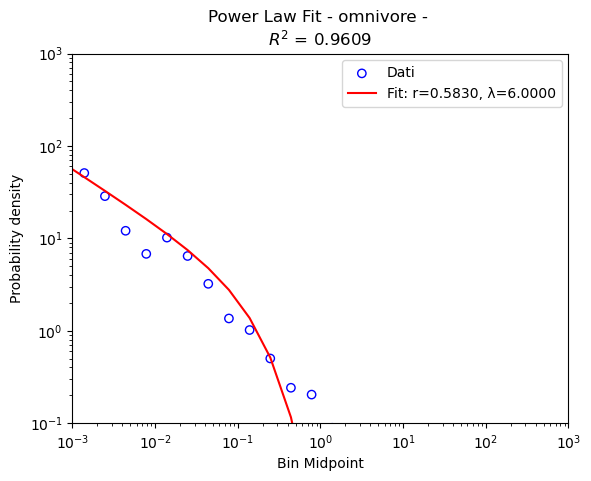

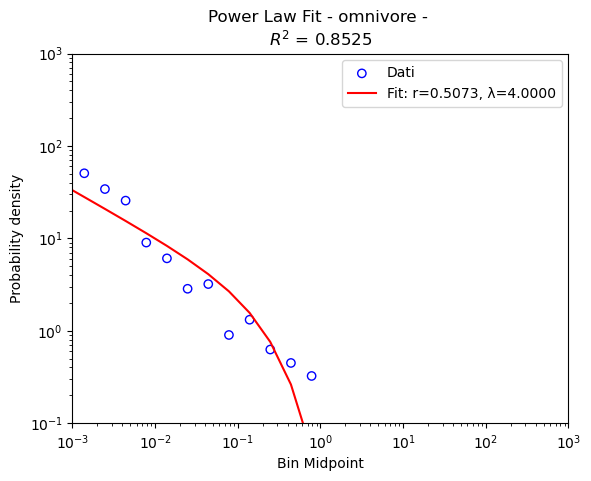

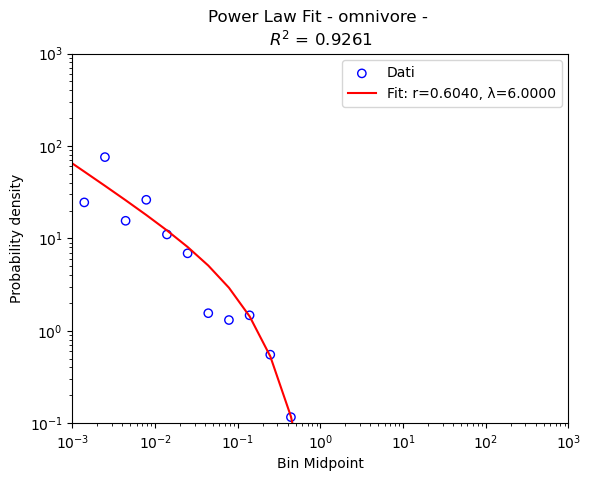

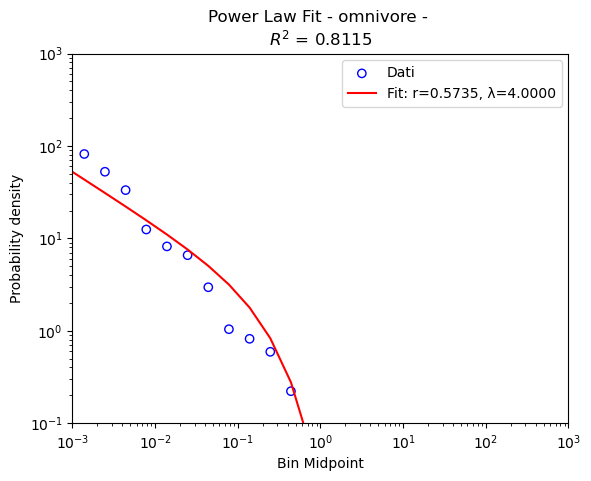

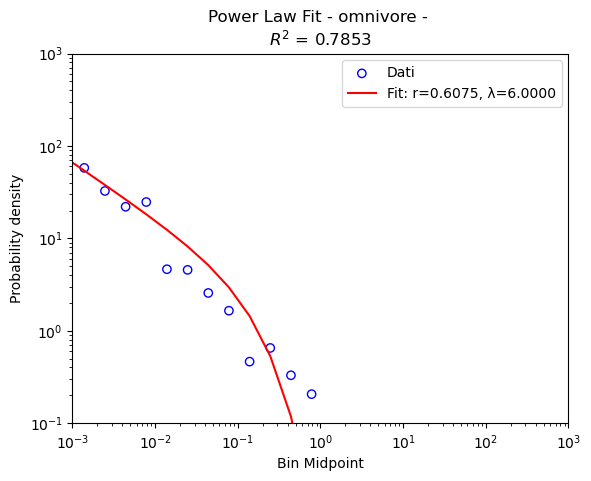

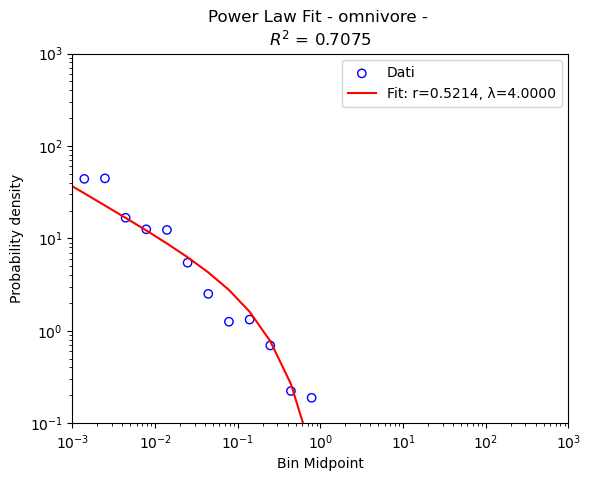

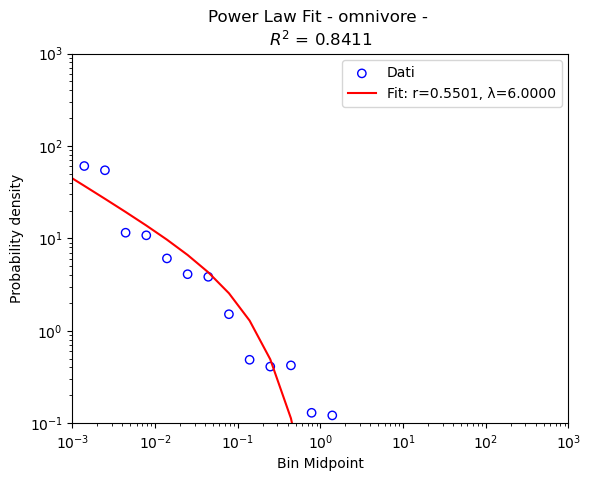

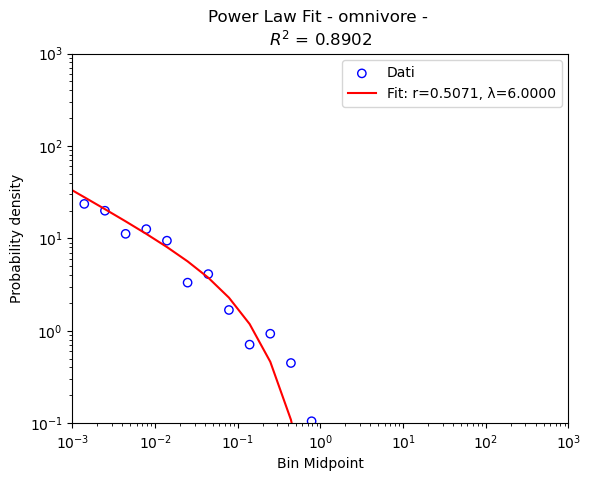

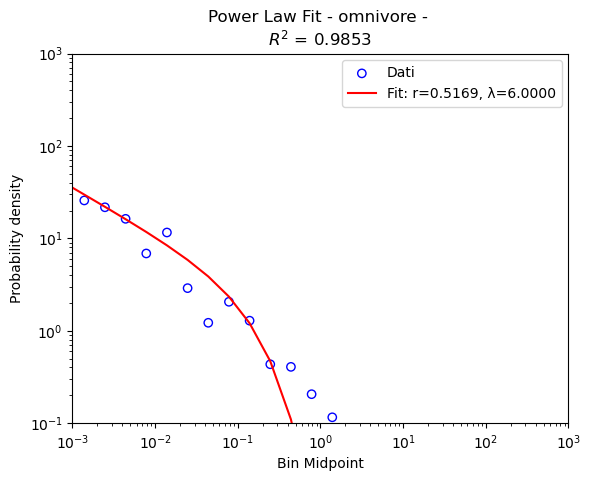

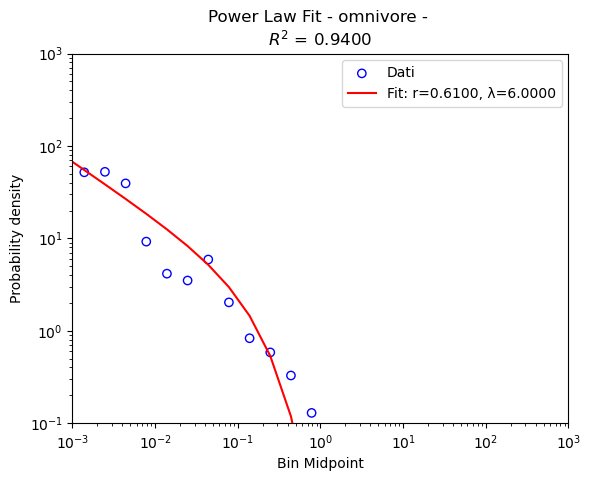

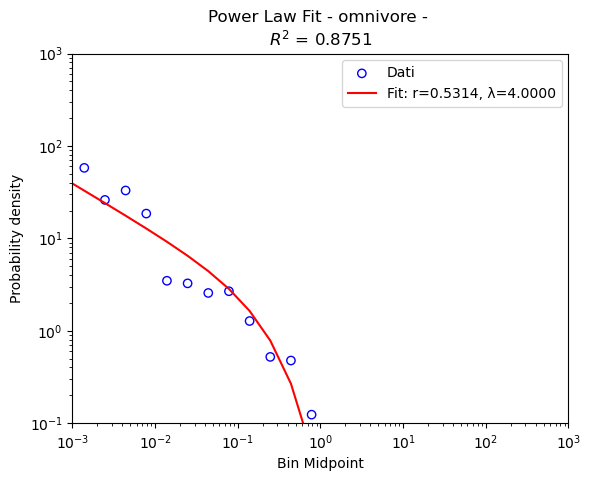

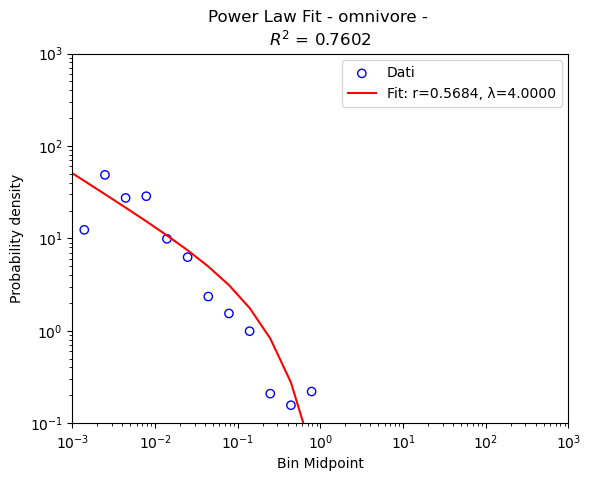

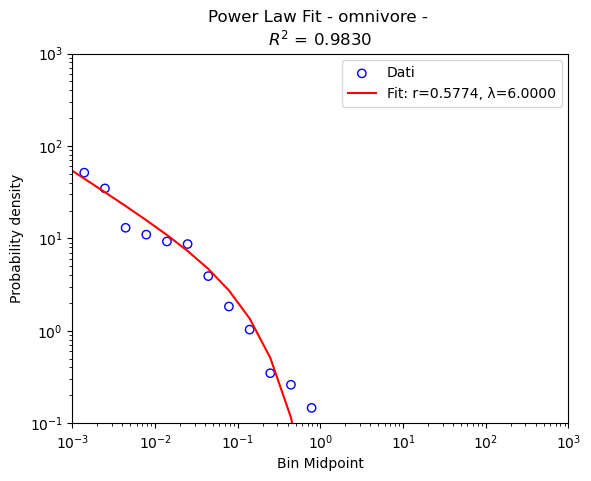

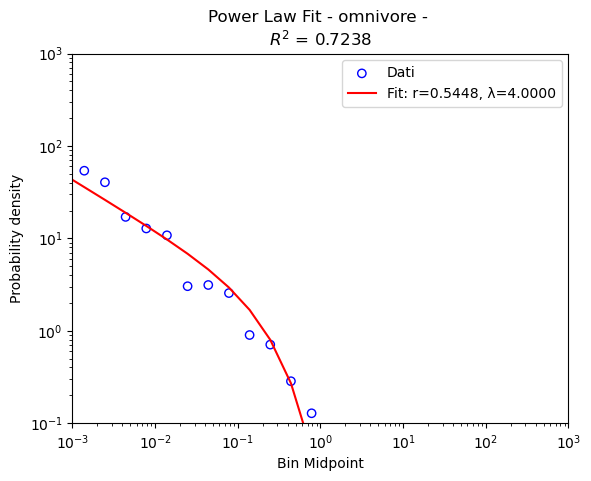

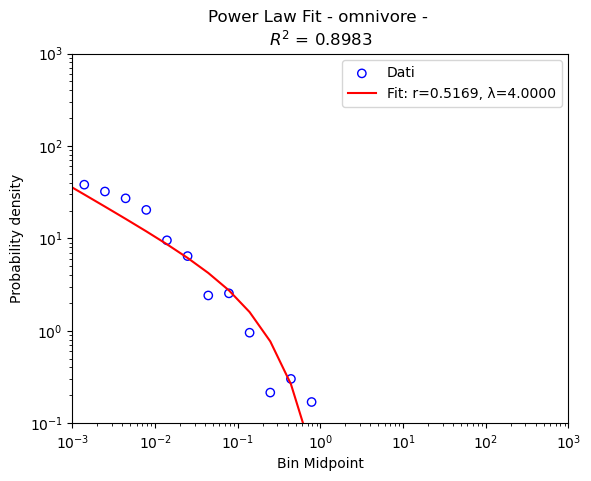

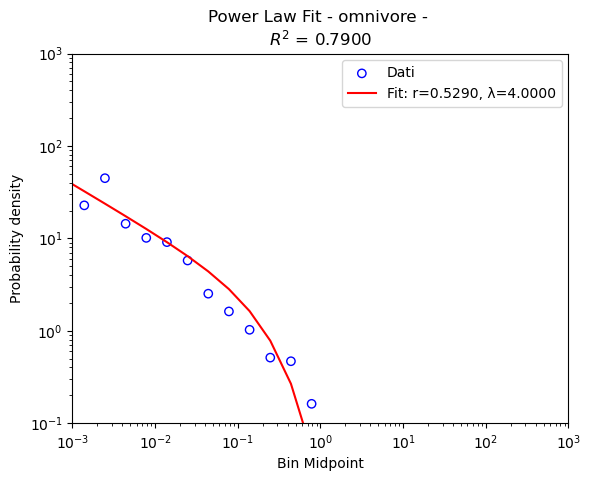

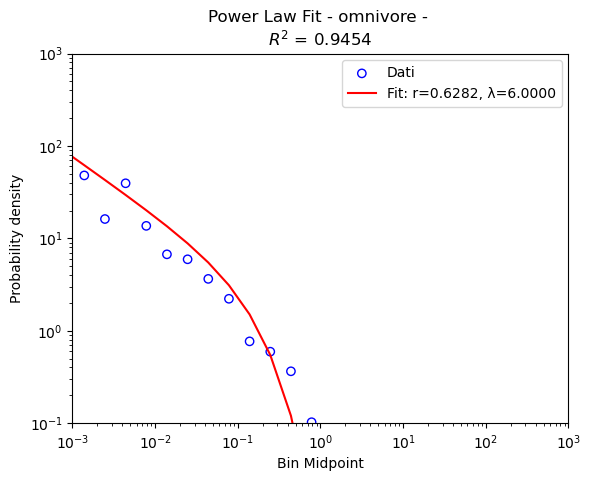

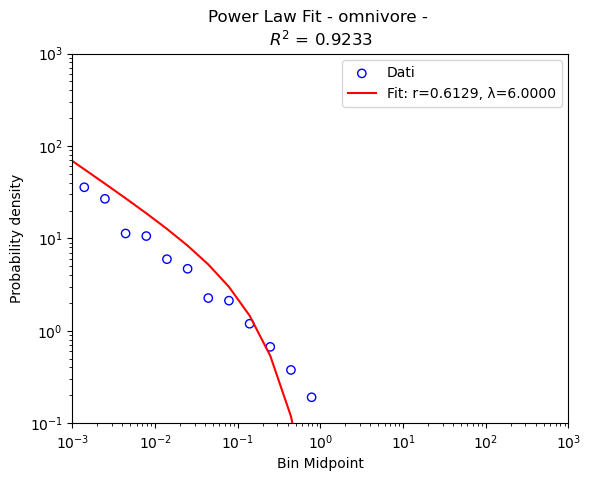

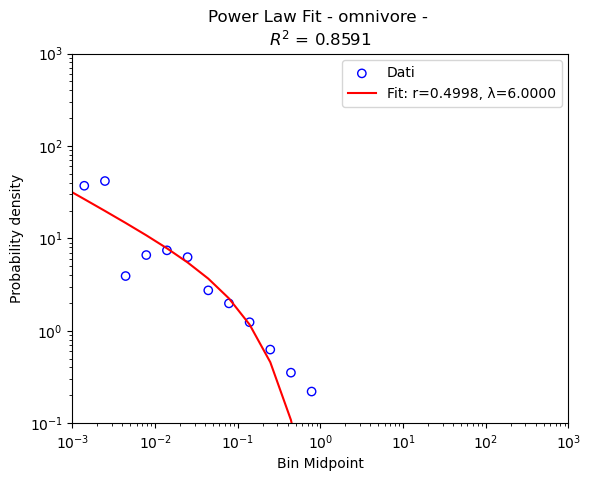

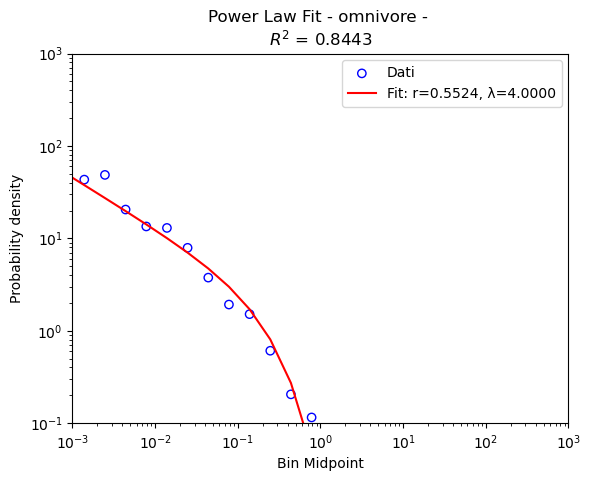

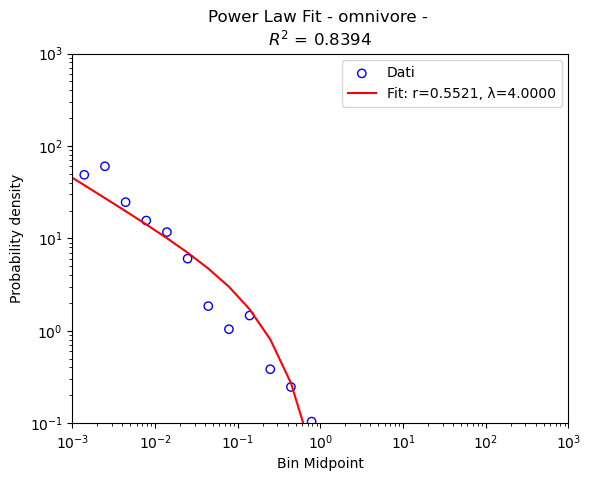

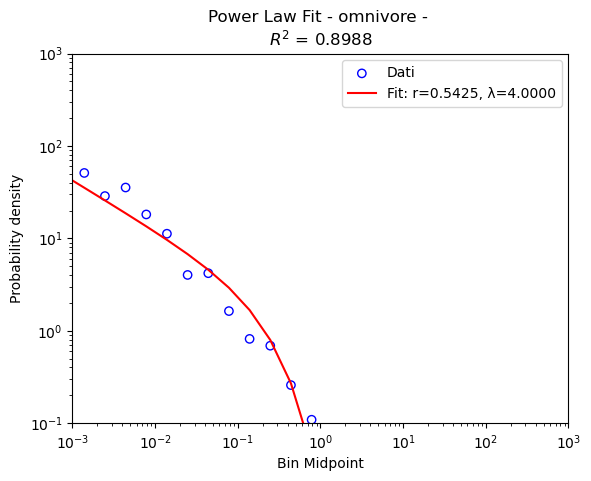

In [16]:


# Fit del modello power law per ogni colonna
fit_results = {}

# Definizione dei limiti per r e λ
lower_bounds = [0, 4]  # Limiti inferiori per r e λ
upper_bounds = [1, 6]   # Limiti superiori per r e λ

# Dizionario per salvare i valori di R²
r_squared_results = {}

for col in range(hist_data.shape[1]):
    x_data = hist_data.index.values  # Bin midpoints
    y_data = hist_data.iloc[:,col]
    diet= metadata_csv.loc[col,"diet"]
   
    # Rimuove eventuali valori zero o NaN per evitare errori di fitting
    mask = (x_data > 0) & (y_data > 0)
    x_data = x_data[mask]
    y_data = y_data[mask]

    # Stima dei parametri iniziali per il fitting
    initial_guess = [0.0006,4.5]

    try:
        # Esegue il fit della funzione power law ai dati con limiti impostati
        popt, _ = curve_fit(
            powerlaw_model,
            x_data,
            y_data,
            p0=initial_guess,
            bounds=(lower_bounds, upper_bounds)  # Impostazione dei limiti
        )
        fit_results[col] = popt
        # Calcolo dei valori previsti dal modello
        y_pred = powerlaw_model(x_data, *popt)

        # Calcolo di R²
        ss_res = np.sum((y_data - y_pred) ** 2)  # Somma dei quadrati dei residui
        ss_tot = np.sum((y_data - np.mean(y_data)) ** 2)  # Somma dei quadrati totali
        r_squared = 1 - (ss_res / ss_tot)
        r_squared_results[col] = r_squared

        # Visualizzazione del fit
        plt.figure()
        plt.scatter(x_data, y_data, marker='o', facecolors='none', edgecolors='blue', label="Dati")
        plt.plot(x_data, powerlaw_model(x_data, *popt), label=f'Fit: r={popt[0]:.4f}, λ={popt[1]:.4f}', color='red')
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim(10e-4, 10e2)
        plt.ylim(10e-2, 10e2)
        plt.xlabel('Bin Midpoint')
        plt.ylabel('Probability density')
        plt.title(f'Power Law Fit - {diet} - \n$R^2$ = {r_squared:.4f}')
        plt.legend()
        plt.show()

    except RuntimeError as e:
        print(f"Fit failed per {col}: {e}")
        fit_results[col] = None



In [17]:
import numpy as np
import pandas as pd

# Convert fit_results and r_squared_results to DataFrame for easier manipulation
fit_df = pd.DataFrame.from_dict(fit_results, orient='index', columns=['r', 'lambda'])
r_squared_df = pd.DataFrame.from_dict(r_squared_results, orient='index', columns=['R_squared'])

# Add diet labels from metadata to the dataframes
fit_df['diet'] = metadata_csv['diet']
r_squared_df['diet'] = metadata_csv['diet']

# Group by diet type and calculate mean and standard deviation
grouped_fit_stats = fit_df.groupby('diet').agg(['mean', 'std'])
grouped_r_squared_stats = r_squared_df.groupby('diet').agg(['mean', 'std'])

# Rename columns for better readability
grouped_fit_stats.columns = ['_'.join(col).strip() for col in grouped_fit_stats.columns.values]
grouped_r_squared_stats.columns = ['_'.join(col).strip() for col in grouped_r_squared_stats.columns.values]

# Combine results
final_results = pd.concat([grouped_fit_stats, grouped_r_squared_stats], axis=1)

